# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch, as well as a few more for convenience.

In [1]:
!pip install -q -r requirements.txt &> /dev/null

> Now please RESTART THE KERNEL IN YOUR NOTEBOOK then continue execution with the next cell.

In [2]:
# import libraries
import torch
import numpy as np
# Progress bar
from tqdm import tqdm
# Will use this to figure out the number of CPUs available
import multiprocessing

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [3]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

NOTE: when executing the following cell you will see a warning `The given NumPy array is not writeable ...`. Please ignore the warning, is due to a little bug in pytorch 1.9.0 that is harmless.

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
# We set this equal to the number of CPUs available
# in this machine
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load. You can experiment
# with this parameter to try to improve performances
batch_size = 64

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [
        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        transforms.ToTensor(),
        # This then renormalize the tensor to be between -1.0 and 1.0,
        # which is a better range for modern activation functions like
        # Relu
        transforms.Normalize((0.5), (0.5)),
    ]
)


# Get train, validation and test

# Let's start with train and validation
trainval_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# Split in train and validation
# NOTE: we set the generator with a fixed random seed for reproducibility
train_len = int(len(trainval_data) * 0.8)
val_len = len(trainval_data) - train_len
print(f"Using {train_len} examples for training and {val_len} for validation")
train_subset, val_subset = torch.utils.data.random_split(
    trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)

# Get test data
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)
print(f"Using {len(test_data)} for testing")

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

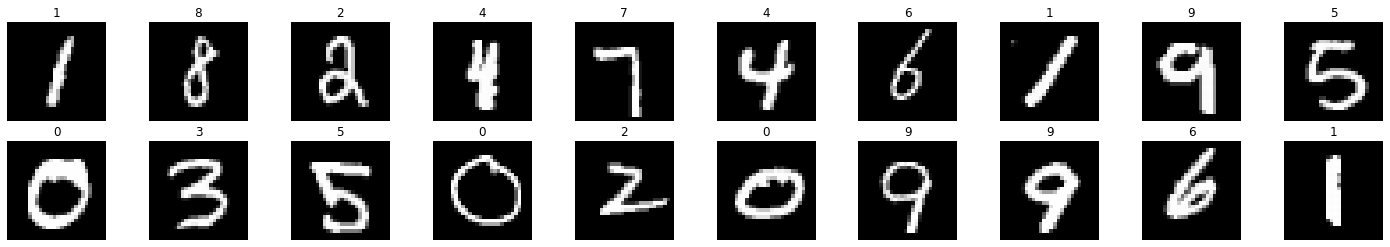

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

### View an Image in More Detail

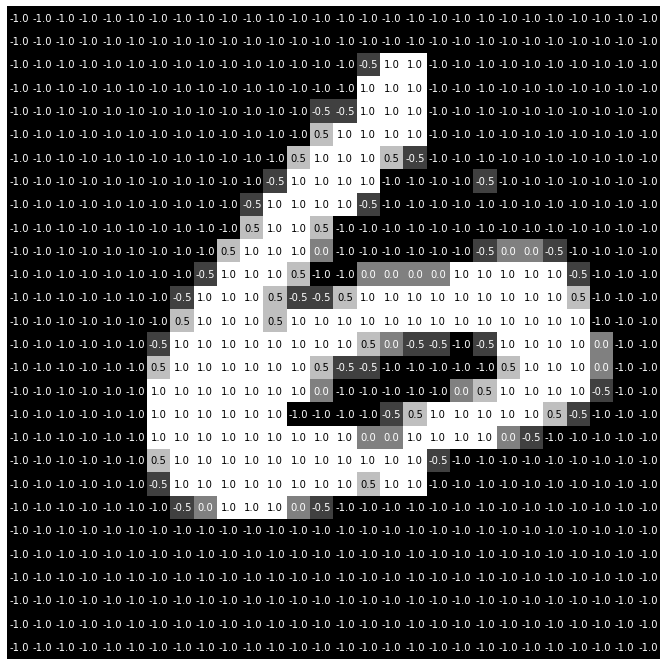

In [6]:
img = np.squeeze(images[1])

fig, sub = plt.subplots(figsize = (12,12)) 
sub.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        sub.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
        sub.axis("off")

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # YOUR CODE HERE
        hidden_1, hidden_2 = 512, 512
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, hidden_1)        
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        
        # YOUR CODE HERE
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# initialize the NN
model = Net()

# NOTE: this is NOT the structure of the network, but merely a
# visualization of the layers that are present. For very simple
# architectures the two might be similar, but for more complicated
# network they will not. See the next cell for a possible way of
# visualizing the real structure of the network
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## (Bonus: visualize the structure of your network)
You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "mnist_network.pt" in this directory), then download the produced `mnist_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [11]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "mnist_network.pt")

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax function to the output layer *and* then calculates the log loss.

In [12]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [13]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_idx, (data, target) in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80,
        ):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validating",
            total=len(val_loader),
            leave=True,
            ncols=80,
        ):

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 2. calculate the loss
            loss_value = criterion(output, target)  # =

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )
    
    print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")

Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.17it/s]

Epoch 1: training loss 1.09110, valid loss 0.47139



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.63it/s]

Epoch 2: training loss 0.38573, valid loss 0.35647



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.55it/s]

Epoch 3: training loss 0.31945, valid loss 0.31660



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 88.24it/s]

Epoch 4: training loss 0.28567, valid loss 0.29133



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 86.94it/s]

Epoch 5: training loss 0.25938, valid loss 0.27768



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.97it/s]

Epoch 6: training loss 0.23670, valid loss 0.24983



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 86.28it/s]

Epoch 7: training loss 0.21635, valid loss 0.23384



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 78.19it/s]

Epoch 8: training loss 0.19829, valid loss 0.21396



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 86.06it/s]

Epoch 9: training loss 0.18287, valid loss 0.20726



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.32it/s]

Epoch 10: training loss 0.16822, valid loss 0.18794



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.37it/s]

Epoch 11: training loss 0.15663, valid loss 0.17885



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 78.84it/s]

Epoch 12: training loss 0.14551, valid loss 0.16895



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.23it/s]

Epoch 13: training loss 0.13628, valid loss 0.17007



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.38it/s]

Epoch 14: training loss 0.12761, valid loss 0.15397



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 84.43it/s]

Epoch 15: training loss 0.11940, valid loss 0.14959



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.93it/s]

Epoch 16: training loss 0.11269, valid loss 0.14359



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.66it/s]

Epoch 17: training loss 0.10621, valid loss 0.13691



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.46it/s]

Epoch 18: training loss 0.10051, valid loss 0.13352



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.90it/s]

Epoch 19: training loss 0.09486, valid loss 0.12881



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.81it/s]

Epoch 20: training loss 0.08995, valid loss 0.12365



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.85it/s]

Epoch 21: training loss 0.08523, valid loss 0.12304



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.04it/s]

Epoch 22: training loss 0.08120, valid loss 0.12118



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 86.58it/s]

Epoch 23: training loss 0.07723, valid loss 0.11687



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.42it/s]

Epoch 24: training loss 0.07374, valid loss 0.11377



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.22it/s]

Epoch 25: training loss 0.06987, valid loss 0.11034



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.78it/s]

Epoch 26: training loss 0.06673, valid loss 0.10478



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.54it/s]

Epoch 27: training loss 0.06375, valid loss 0.10535



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.41it/s]

Epoch 28: training loss 0.06062, valid loss 0.10483



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.95it/s]


Epoch 29: training loss 0.05787, valid loss 0.10056


Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.14it/s]

Epoch 30: training loss 0.05533, valid loss 0.09984



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 84.60it/s]

Epoch 31: training loss 0.05261, valid loss 0.09756



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.60it/s]

Epoch 32: training loss 0.05027, valid loss 0.09641



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.75it/s]

Epoch 33: training loss 0.04783, valid loss 0.09741



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 87.27it/s]

Epoch 34: training loss 0.04644, valid loss 0.09441



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.35it/s]

Epoch 35: training loss 0.04416, valid loss 0.09323



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.77it/s]

Epoch 36: training loss 0.04259, valid loss 0.09480



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 78.18it/s]

Epoch 37: training loss 0.04046, valid loss 0.09031



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.07it/s]

Epoch 38: training loss 0.03886, valid loss 0.09490



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 84.41it/s]

Epoch 39: training loss 0.03733, valid loss 0.08942



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.88it/s]

Epoch 40: training loss 0.03579, valid loss 0.08769



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.16it/s]

Epoch 41: training loss 0.03442, valid loss 0.08785



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.52it/s]

Epoch 42: training loss 0.03277, valid loss 0.09186



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.30it/s]

Epoch 43: training loss 0.03162, valid loss 0.08726



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 81.80it/s]

Epoch 44: training loss 0.03016, valid loss 0.08757



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.63it/s]

Epoch 45: training loss 0.02899, valid loss 0.09188



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.40it/s]

Epoch 46: training loss 0.02812, valid loss 0.08506



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 76.58it/s]

Epoch 47: training loss 0.02660, valid loss 0.08882



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.00it/s]

Epoch 48: training loss 0.02558, valid loss 0.08339



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 80.84it/s]

Epoch 49: training loss 0.02466, valid loss 0.08718



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 77.24it/s]

Epoch 50: training loss 0.02365, valid loss 0.08452


---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [14]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()  # prep model for *evaluation*

for batch_idx, (data, target) in tqdm(
    enumerate(test_loader),
    desc="Testing",
    total=len(test_loader),
    leave=True,
    ncols=80,
):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(10):
    if class_total[i] > 0:
        print(
            f"Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}%% "
            f"({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})"
        )
    else:
        print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")

print(
    f"\nTest Accuracy (Overall): {100.0 * np.sum(class_correct) / np.sum(class_total)}%% "
    f"({int(np.sum(class_correct))}/{int(np.sum(class_total))})"
)

Testing: 100%|████████████████████████████████| 157/157 [00:02<00:00, 75.20it/s]

Test Loss: 0.075088

Test Accuracy of 0: 98.57%% (966/980)
Test Accuracy of 1: 99.30%% (1127/1135)
Test Accuracy of 2: 98.55%% (1017/1032)
Test Accuracy of 3: 98.22%% (992/1010)
Test Accuracy of 4: 97.76%% (960/982)
Test Accuracy of 5: 97.42%% (869/892)
Test Accuracy of 6: 98.23%% (941/958)
Test Accuracy of 7: 96.01%% (987/1028)
Test Accuracy of 8: 97.02%% (945/974)
Test Accuracy of 9: 96.73%% (976/1009)

Test Accuracy (Overall): 97.8%% (9780/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

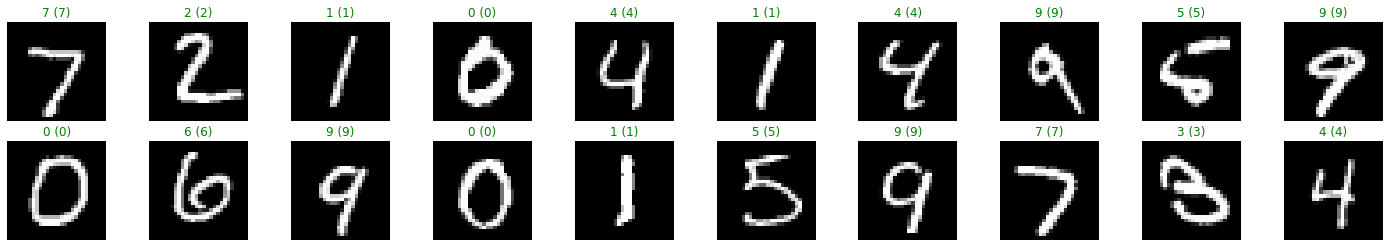

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(range(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    sub.set_title(f"{str(preds[idx].item())} ({str(labels[idx].item())})",
                 color=("green" if preds[idx]==labels[idx] else "red"))
    sub.axis("off")